/tmp/ipykernel_5744/2144297272.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_anomaly_iforest'] = iso_preds
/tmp/ipykernel_5744/2144297272.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_anomaly_ocsvm'] = svm_preds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 20.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 38.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 37.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 43.4 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4
  Consider

2025-06-27 05:49:55.496841: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 05:49:56.042882: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 05:49:56.304925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751003396.499063    5744 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751003396.544988    5744 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751003397.089743    5744 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


/tmp/ipykernel_5744/2144297272.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_anomaly_autoenc'] = ae_preds


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step

Isolation Forest:
Precision: 0.000, Recall: 0.000, F1: 0.000

One-Class SVM:
Precision: 0.000, Recall: 0.000, F1: 0.000

Autoencoder:
Precision: 0.000, Recall: 0.000, F1: 0.000

LSTM Autoencoder:
Precision: 0.000, Recall: 0.000, F1: 0.000

Summary of Advanced Model Results:
              Model  Precision  Recall   F1
0  Isolation Forest        0.0     0.0  0.0
1     One-Class SVM        0.0     0.0  0.0
2       Autoencoder        0.0     0.0  0.0
3  LSTM Autoencoder        0.0     0.0  0.0


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/m

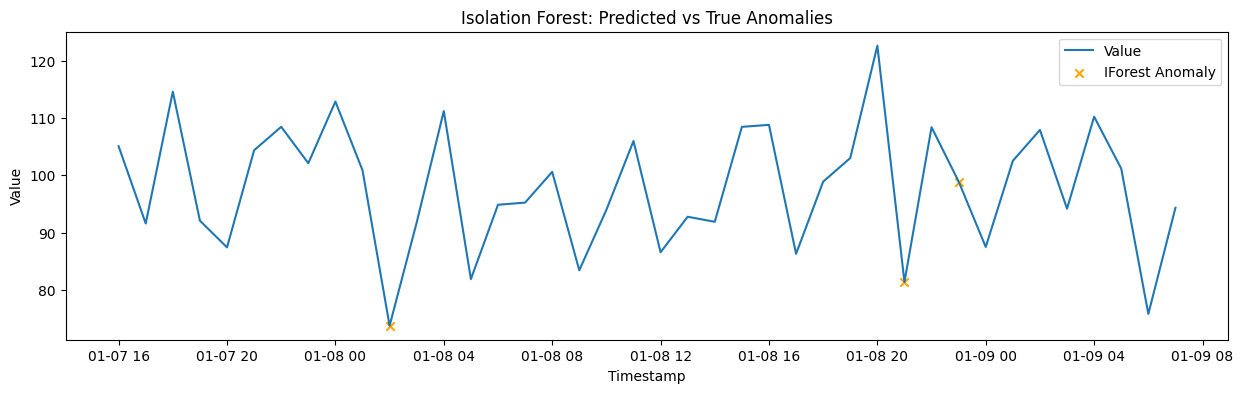

In [3]:
# Advanced ML/DL Models for Time Series Anomaly Detection

import sys
import os
sys.path.append(os.path.abspath("../src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# -------------------------------------------
# Load cleaned data
data_dir = "../data/processed/aws_cloudwatch_data"
metric_name = "grok_asg"  # Change as needed
csv_path = os.path.join(data_dir, f"{metric_name}_cleaned.csv")
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"File not found: {csv_path}. Please check that the file exists and the path is correct.")
df = pd.read_csv(csv_path, parse_dates=['timestamp'])


# -------------------------------------------
# Feature Engineering
df = df.sort_values('timestamp')
df['rolling_mean'] = df['value'].rolling(24, min_periods=1).mean()
df['rolling_std'] = df['value'].rolling(24, min_periods=1).std().fillna(0)
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek

features = ['value', 'rolling_mean', 'rolling_std', 'hour', 'dayofweek']
X = df[features].fillna(0)


# -------------------------------------------
# Train/Test Split (last 20% as test)
test_frac = 0.2
n_test = int(len(df) * test_frac)
X_train, X_test = X[:-n_test], X[-n_test:]
df_train, df_test = df[:-n_test], df[-n_test:]


# -------------------------------------------
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# -------------------------------------------
# 1. Isolation Forest (as reference)
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.01, random_state=42)
iso.fit(X_train_scaled)
iso_preds = iso.predict(X_test_scaled)
iso_preds = (iso_preds == -1).astype(int)
df_test['pred_anomaly_iforest'] = iso_preds


# -------------------------------------------
# 2. One-Class SVM
from sklearn.svm import OneClassSVM

oc_svm = OneClassSVM(nu=0.01, kernel="rbf", gamma='scale')
oc_svm.fit(X_train_scaled)
svm_preds = oc_svm.predict(X_test_scaled)
svm_preds = (svm_preds == -1).astype(int)
df_test['pred_anomaly_ocsvm'] = svm_preds


# -------------------------------------------
# 3. Autoencoder (Keras)
%pip install tensorflow

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers

input_dim = X_train_scaled.shape[1]
encoding_dim = min(8, input_dim // 2)

input_layer = Input(shape=(input_dim, ))
encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder = Model(inputs=input_layer, outputs=decoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=32, shuffle=True, validation_split=0.1, verbose=0)

# Reconstruction error on test set
reconstructions = autoencoder.predict(X_test_scaled)
mse = np.mean(np.square(X_test_scaled - reconstructions), axis=1)
ae_threshold = np.percentile(mse, 99)  # Top 1% as anomalies
ae_preds = (mse > ae_threshold).astype(int)
df_test['pred_anomaly_autoenc'] = ae_preds


# -------------------------------------------
# 4. LSTM Autoencoder (Keras)
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed

timesteps = 10  # window size
def create_sequences(X, timesteps):
    Xs = []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:(i + timesteps)])
    return np.array(Xs)

X_train_seq = create_sequences(X_train_scaled, timesteps)
X_test_seq = create_sequences(X_test_scaled, timesteps)

input_dim = X_train_seq.shape[2]
lstm_input = Input(shape=(timesteps, input_dim))
encoded = LSTM(16, activation='relu')(lstm_input)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, activation='relu', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(input_dim))(decoded)
lstm_autoencoder = Model(lstm_input, decoded)
lstm_autoencoder.compile(optimizer='adam', loss='mse')

lstm_autoencoder.fit(X_train_seq, X_train_seq, epochs=30, batch_size=32, validation_split=0.1, verbose=0)


# Reconstruction error on test set
X_test_pred = lstm_autoencoder.predict(X_test_seq)
mse_lstm = np.mean(np.square(X_test_seq - X_test_pred), axis=(1,2))
lstm_threshold = np.percentile(mse_lstm, 99)
lstm_preds = (mse_lstm > lstm_threshold).astype(int)
# For LSTM, ground truth must be offset:
if 'label' in df_test.columns:
    y_true_lstm = df_test['label'].values[timesteps:]
else:
    y_true_lstm = None


# -------------------------------------------
# Evaluation & Summary
results = []
if 'label' in df_test.columns:
    y_true = df_test['label'].values

    for name, pred in [
        ('Isolation Forest', iso_preds),
        ('One-Class SVM', svm_preds),
        ('Autoencoder', ae_preds)
    ]:
        p = precision_score(y_true, pred)
        r = recall_score(y_true, pred)
        f1 = f1_score(y_true, pred)
        results.append({'Model': name, 'Precision': p, 'Recall': r, 'F1': f1})
        print(f"\n{name}:\nPrecision: {p:.3f}, Recall: {r:.3f}, F1: {f1:.3f}")

    if y_true_lstm is not None:
        p = precision_score(y_true_lstm, lstm_preds)
        r = recall_score(y_true_lstm, lstm_preds)
        f1 = f1_score(y_true_lstm, lstm_preds)
        results.append({'Model': 'LSTM Autoencoder', 'Precision': p, 'Recall': r, 'F1': f1})
        print(f"\nLSTM Autoencoder:\nPrecision: {p:.3f}, Recall: {r:.3f}, F1: {f1:.3f}")

    # Summary table
    results_df = pd.DataFrame(results)
    print("\nSummary of Advanced Model Results:")
    print(results_df)


# -------------------------------------------
# Visualization Example (Isolation Forest)
plt.figure(figsize=(15,4))
plt.plot(df_test['timestamp'], df_test['value'], label='Value')
plt.scatter(df_test.loc[df_test['pred_anomaly_iforest']==1, 'timestamp'],
            df_test.loc[df_test['pred_anomaly_iforest']==1, 'value'],
            color='orange', marker='x', label='IForest Anomaly')
if 'label' in df_test.columns and df_test['label'].sum()>0:
    plt.scatter(df_test.loc[df_test['label']==1, 'timestamp'],
                df_test.loc[df_test['label']==1, 'value'],
                color='red', marker='o', facecolors='none', label='True Anomaly')
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()
plt.title("Isolation Forest: Predicted vs True Anomalies")
plt.show()